## Plot Gradient of Electron Density on a Plane
Assumes you have python 2, numpy, chemtools and matplotlib installed.

The process is as follows:

1. Figure out the rotation/translation so that the molecular coordinates lie on the x,y-plane.
2. Construct a grid in the x-y-plane that contains the molecular coordinates.
3. Rotate back this grid to the affine plane in 3D.
4. Compute the gradient of the electron density at each of the points of the affine plane.
5. Project the gradient so that they lie on the plane
6. Rotate the gradient so that they lie on the x,y-plane.
7. Plot them in 2D

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Need this to plot in 3D

from chemtools.wrappers.molecule import Molecule

# Construct Molecule object to calculate the electron density and gradient
mol = Molecule.from_file("./data/h2o.fchk")
print("Molecular Coordinates:")
print(mol.coordinates)
print("Molecular Charge:")
print(mol.numbers)

Initialized: <horton.gbasis.cext.GOBasis object at 0x7f6699c269f0>
  Number of basis functions         : 41
  Number of normalization constants : 65
  Maximum shell type                : 2
  Center     0 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     1 :  S3 S1 S1 P1 P1
  Center     2 :  S3 S1 S1 P1 P1

Molecular Coordinates:
[[ 0.01594845  0.01700428  0.023858  ]
 [-0.77277844  0.56144655  1.57501231]
 [ 1.29850109  1.26951236 -0.30911333]]
Molecular Charge:
[8 1 1]


Water is a planar molecule, and so the coordinates should be lying on an affine plane.

Rotate the plane to lie on the x-y axis, then plot it as a 2D vector field.
See https://math.stackexchange.com/questions/1167717/transform-a-plane-to-the-xy-plane

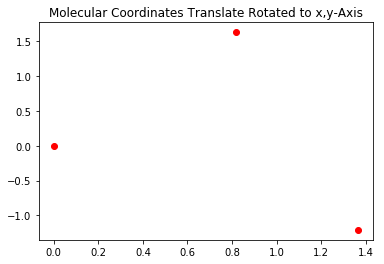

In [37]:
coord = mol.coordinates
# Construct the two vectors that lie on the plane.
v1, v2 = coord[1] - coord[0], coord[2] - coord[0]
# Calculate normal vector to the plane
#    The normal vector is a vector of norm 1, that is orthogonal to every vector of the plane.
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)

# Figure out the rotation matrix from the plane to the x,y-axis.
a, b, c = normal
cos_theta = c
sin_theta = np.sqrt(a**2.0 + b**2.0)
u_1 = b / np.sqrt(a**2.0 + b**2.0)
u_2 = -a / np.sqrt(a**2.0 + b**2.0)
rot = np.array([
    [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
    [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
    [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
])

# Rotate the molecular coordinates.
rot_coords = np.dot(rot, (coord - coord[0]).T).T
assert np.all(np.abs(rot_coords[:, 2]) < 1e-5)  # Make sure the z-axis is zero.
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro")
plt.title("Molecular Coordinates Translate Rotated to x,y-Axis")
plt.show()

Construct a Two-dimensional grid that contains the molecules

[-1.         -2.20745749 -1.        ]


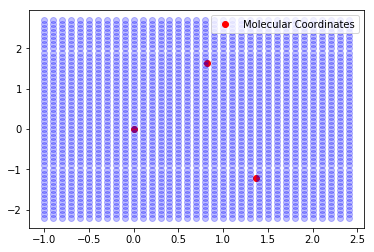

In [38]:
l_bnd = np.min(rot_coords, axis=0) - 1
u_bnd = np.max(rot_coords, axis=0) + 1
print(l_bnd)
step_size = 0.1
x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)

plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.plot(grid_2d[:, 0], grid_2d[:, 1], "bo", alpha=0.25)
plt.legend()
plt.show()

Rotate this 2d grid back into 3D and calculate the gradient of electron density.

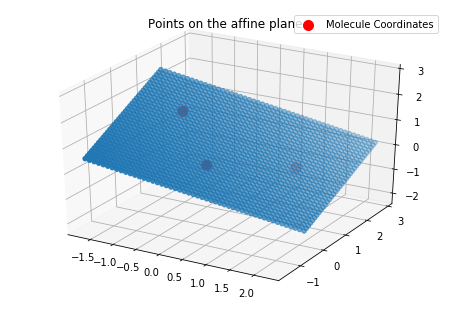

In [39]:
# Add zero z-axis and rotate it and translate it to the plane
grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
assert np.all(np.abs(np.dot(grid_plane, normal)) < 1e-5)
grid_plane += coord[0]


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(grid_plane[:, 0], grid_plane[:, 1], grid_plane[:, 2])
ax.scatter(coord[:, 0], coord[:, 1], coord[:, 2], c="r", s=100,
           label="Molecule Coordinates")
plt.legend()
plt.title("Points on the affine plane.")
plt.show()

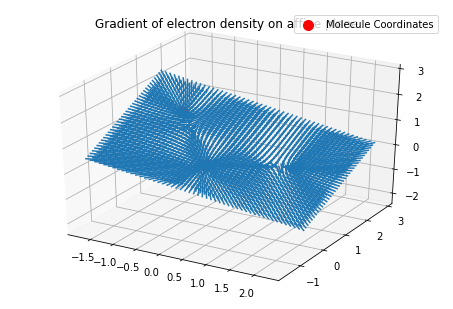

In [40]:
gradients = mol.compute_gradient(grid_plane)

# Plot the Three-dimensional vector field.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(coord[:, 0], coord[:, 1], coord[:, 2], c="r", s=100,
           label="Molecule Coordinates")
ax.quiver(grid_plane[:, 0],grid_plane[:, 1], grid_plane[:, 2],
          gradients[:, 0], gradients[:, 1], gradients[:, 2], length=0.25,
          normalize=True)
plt.title("Gradient of electron density on affine plane")
plt.legend()
plt.show()

Project the gradient onto the plane, then rotate it back into 2D space.
https://www.maplesoft.com/support/help/maple/view.aspx?path=MathApps%2FProjectionOfVectorOntoPlane

In [41]:

# Project gradient onto the plane
proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
# Make sure it is on the plane by making sure it is orthogonal to the normal.
assert np.all(np.dot(proj_gradients, normal) < 1e-5)
# Rotate the projected gradients onto two-dimensions.
rot_proj_gradients = np.dot(rot, proj_gradients.T).T
assert np.all(np.abs(rot_proj_gradients[:, 2]) < 1e-8)

Finally plot it in 2D space.

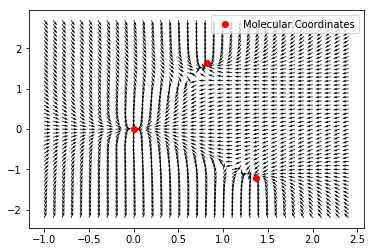

In [42]:
# Rotate Projected Plane.
rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1], scale=50)
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.legend()
plt.show()